# TFX and functional API

This notebook is partly based on the TensorFlow documentation about [loading and preprocessing data](https://www.tensorflow.org/tutorials/load_data/csv).

# Setup

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import urllib.request
import os

## Import data

In [1]:
# Create variable with name of directory
DATA_ROOT = 'data'

# Create a directory called data-penguin
os.mkdir(DATA_ROOT)  

# URL with data
_data_url = 'https://raw.githubusercontent.com/kirenz/datasets/master/palmer-penguins.csv'

# Create filepath to data and name file data.csv
_data_filepath = os.path.join(DATA_ROOT, "data.csv")

# Fetch data
urllib.request.urlretrieve(_data_url, _data_filepath)

('data/data.csv', <http.client.HTTPMessage at 0x7fa938717880>)

The dataset we are using is
[Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/articles/intro.html)

The data contains size measurements for three penguin species observed on three islands in the Palmer Archipelago, Antarctica:

![](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)

*Picture: The Palmer Archipelago penguins. Artwork by @allison_horst*


There are four numeric features in this dataset:

- bill_length_mm 
- bill_depth_mm
- flipper_length_mm
- body_mass_g

As well as categorical features:

- island
- sex
- year

![](https://allisonhorst.github.io/palmerpenguins/reference/figures/culmen_depth.png)


We want to build a classification model which predicts the `species` of penguins.

Show head of CSV file:

In [2]:
!head {_data_filepath}

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
Adelie,Torgersen,39.1,18.7,181,3750,male,2007
Adelie,Torgersen,39.5,17.4,186,3800,female,2007
Adelie,Torgersen,40.3,18,195,3250,female,2007
Adelie,Torgersen,NA,NA,NA,NA,NA,2007
Adelie,Torgersen,36.7,19.3,193,3450,female,2007
Adelie,Torgersen,39.3,20.6,190,3650,male,2007
Adelie,Torgersen,38.9,17.8,181,3625,female,2007
Adelie,Torgersen,39.2,19.6,195,4675,male,2007
Adelie,Torgersen,34.1,18.1,193,3475,NA,2007


Let's use pandas to import the data:

In [3]:
df = pd.read_csv(_data_filepath)
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


Here, we simply drop all missing entries.

In [5]:
df.dropna(inplace=True)

## Keras data preprocessing

We will use the [Keras functional API](https://keras.io/guides/functional_api/), which is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

Because of the different data types and ranges you can't simply stack the features into NumPy array and pass it to a keras.Sequential model. Each column needs to be handled individually.

As one option, you could preprocess your data offline (using any tool you like) to convert categorical columns to numeric columns, then pass the processed output to your TensorFlow model. The disadvantage to that approach is that if you save and export your model the preprocessing is not saved with it. The Keras preprocessing layers avoid this problem because they're part of the model.

In this example, you'll build a model that implements the preprocessing logic using Keras functional API. The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build representation of the calculation, that you can run later. Here's a quick example:



In [6]:
# Our features for the model
_FEATURE_KEYS = [
    'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
    'island', 'sex'
]

# Our y label
_LABEL_KEY = 'species'

In [7]:
df_features = df[_FEATURE_KEYS]
df_labels = df[_LABEL_KEY]

To build the preprocessing model, start by building a set of symbolic keras.Input objects, matching the names and data-types of the CSV columns.



In [29]:
inputs = {}

for name, column in df_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'bill_length_mm': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bill_length_mm')>,
 'bill_depth_mm': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bill_depth_mm')>,
 'flipper_length_mm': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'flipper_length_mm')>,
 'body_mass_g': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'body_mass_g')>,
 'island': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'island')>,
 'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>}

The first step in your preprocessing logic is to:

1. concatenate the numeric inputs together
2. and run them through a normalization layer


In [30]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))

norm = layers.Normalization()

norm.adapt(np.array(df[numeric_inputs.keys()]))

all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization_2')>

Collect all the symbolic preprocessing results, to concatenate them later.



In [31]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the tf.keras.layers.StringLookup function to map from strings to integer indices in a vocabulary. Next, use tf.keras.layers.CategoryEncoding to convert the indexes into float32 data appropriate for the model.

The default settings for the tf.keras.layers.CategoryEncoding layer create a one-hot vector for each input. A layers.Embedding would also work. See the [preprocessing layers guide](https://www.tensorflow.org/guide/keras/preprocessing_layers#quick_recipes) and [tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) for more on this topic.

In [32]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(df_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

With the collection of inputs and processed_inputs, you can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

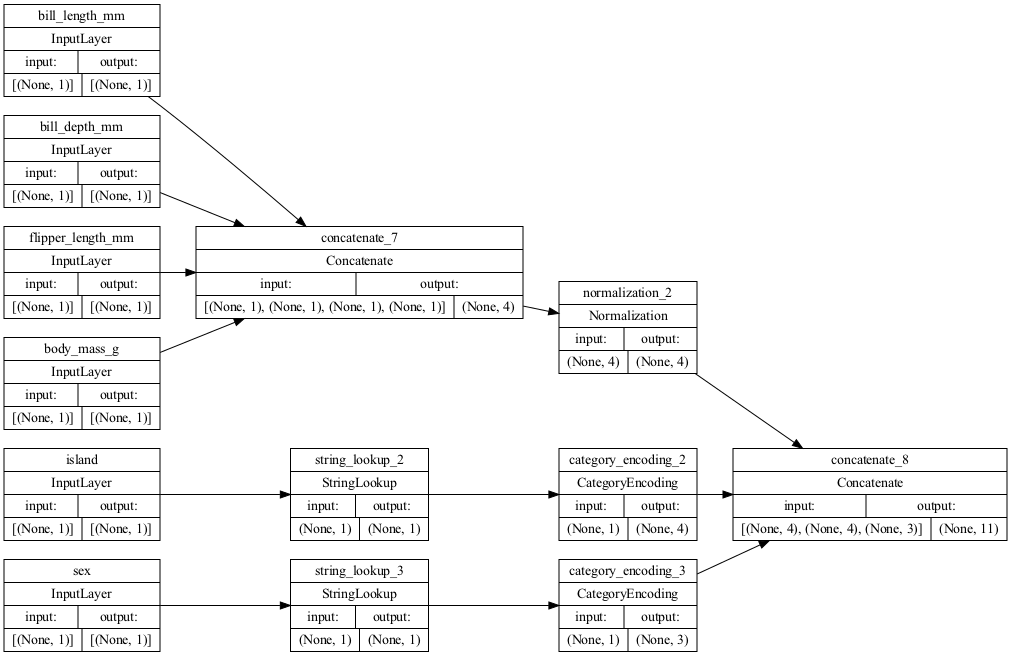

In [33]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

df_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = df_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

This model just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert Pandas DataFrames because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So convert it to a dictionary of tensors:

In [34]:
df_features_dict = {name: np.array(value) 
                         for name, value in df_features.items()}

Slice out the first training example and pass it to this preprocessing model, you see the numeric features and string one-hots all concatenated together:



In [35]:
features_dict = {name:values[:1] for name, values in df_features_dict.items()}
df_preprocessing(features_dict)

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[-0.8960427,  0.7807312, -1.4267532, -0.5684748,  0.       ,
         0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
         1.       ]], dtype=float32)>

Now build the model on top of this:



In [40]:
def df_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(3)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam())
  return model

df_mod = df_model(df_preprocessing, inputs)

In [41]:
df_mod.fit(x=df_features_dict, y=df_labels, epochs=1)

2022-03-31 20:48:04.630129: W tensorflow/core/framework/op_kernel.cc:1722] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to int64 is not supported


UnimplementedError:  Cast string to int64 is not supported
	 [[node sparse_categorical_crossentropy/Cast
 (defined at /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/backend.py:1977)
]] [Op:__inference_train_function_4455]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/Cast:
In[0] IteratorGetNext (defined at /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py:866)

Operation defined at: (most recent call last)
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2957, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3003, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3228, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/35/43bdsj9j64j16410rds5g9vr0000gp/T/ipykernel_25736/4063072077.py", line 1, in <cell line: 1>
>>>     df_mod.fit(x=df_features_dict, y=df_labels, epochs=1)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/backend.py", line 5098, in sparse_categorical_crossentropy
>>>     target = cast(target, 'int64')
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/backend.py", line 1977, in cast
>>>     return tf.cast(x, dtype)
>>> 

In [22]:
# Declare an input (sample has shape 1,1)
inputs = [keras.Input(shape=(1,), name=f) for f in _FEATURE_KEYS]

# Create a layer to combine inputs from all features
features = layers.Concatenate(inputs)

#for _ in range(2):
#    features = keras.layers.Dense(8, activation='relu')(features)


In [ ]:
  for _ in range(2):
    d = keras.layers.Dense(8, activation='relu')(d)
  outputs = keras.layers.Dense(3)(d)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model

In [69]:
from absl import logging

def df_model(preprocessing_head, inputs):
  body = tf.keras.layers.Dense([
    layers.Dense(8, activation='relu'),
    layers.Dense(3)
  ])

  preprocessed_inputs = preprocessing_head(inputs)

  result = body(preprocessed_inputs)

  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)

  return model

df_model = df_model(df_preprocessing, inputs)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [ ]:
  inputs = [keras.layers.Input(shape=(1,), name=f) for f in _FEATURE_KEYS]
  d = keras.layers.concatenate(inputs)
  for _ in range(2):
    d = keras.layers.Dense(8, activation='relu')(d)
  outputs = keras.layers.Dense(3)(d)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model

When you train the model, pass the dictionary of features as x, and the label as y.



In [51]:
df_model.fit(x=df_features_dict, y=df_labels, epochs=1)

2022-03-31 13:27:50.274455: W tensorflow/core/framework/op_kernel.cc:1722] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError:  Cast string to float is not supported
	 [[node binary_crossentropy/Cast
 (defined at /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py:1797)
]] [Op:__inference_train_function_2432]

Errors may have originated from an input operation.
Input Source operations connected to node binary_crossentropy/Cast:
In[0] IteratorGetNext (defined at /Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py:866)

Operation defined at: (most recent call last)
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2957, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3003, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3228, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/sl/9n0p_v712g9ftpzq9r9c254w0000gn/T/ipykernel_6646/2256377437.py", line 1, in <cell line: 1>
>>>     df_model.fit(x=df_features_dict, y=df_labels, epochs=1)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 1797, in binary_crossentropy
>>>     y_true = tf.cast(y_true, y_pred.dtype)
>>> 

In [6]:
from tensorflow import keras
from absl import logging


inputs = [keras.layers.Input(shape=(1,), name=f) for f in _FEATURE_KEYS]

d = keras.layers.concatenate(inputs)

for _ in range(2):
    d = keras.layers.Dense(8, activation='relu')(d)

outputs = keras.layers.Dense(3)(d)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary(print_fn=logging.info)

In [7]:
# Our features for the model
_FEATURE_KEYS = [
    'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
]

# Our y label
_LABEL_KEY = 'species'

# Size of batch during training
_TRAIN_BATCH_SIZE = 20

# Size of batch during evaluation
_EVAL_BATCH_SIZE = 10